In [1]:
%load_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
print('load data')
path = '../../dgym-data'

deck = dg.MoleculeCollection.from_sdf(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

load data


In [2]:
from meeko import MoleculePreparation
from meeko import PDBQTWriterLegacy

def get_pdbqt(mol):

    # add hydrogens (without regard to pH)
    protonated_mol = rdkit.Chem.AddHs(mol)

    # generate 3D coordinates for the ligand. 
    rdkit.Chem.AllChem.EmbedMolecule(protonated_mol)

    # intialize preparation
    preparator = MoleculePreparation()
    mol_setups = preparator.prepare(protonated_mol)
    
    for setup in mol_setups:
        pdbqt_string, is_ok, error_msg = PDBQTWriterLegacy.write_string(setup)
        if is_ok:
            return pdbqt_string

Create ligand PDBQTs.

In [40]:
import os
from tqdm.notebook import tqdm

out_dir = '../../dgym-data/out/ligands_temp/'

paths = []
for mol in tqdm(deck[:]):
    path = os.path.join(out_dir, f'{mol.name}.pdbqt')
    paths.append(path)
    pdbqt = get_pdbqt(mol.mol)
    
    with open(path, 'w') as file:
        file.write(pdbqt)

ligands_txt = ' '.join(paths)
path = os.path.join(out_dir, 'ligands.txt')
with open(path, 'w') as file:
    file.write(ligands_txt)

  0%|          | 0/860 [00:00<?, ?it/s]

Create ligand txt summary file.

In [41]:
# import subprocess
# import tempfile

# with tempfile.TemporaryDirectory() as tempdir:
#     print(f"Temporary directory created at {tempdir}")

In [62]:
%%time
import subprocess

command = 'unidock --receptor ../../dgym-data/Mpro_prepped.pdbqt --ligand_index ../../dgym-data/out/ligands_temp/ligands.txt --center_x 9.812 --center_y -0.257 --center_z 20.8485 --size_x 14.328 --size_y 8.85 --size_z 12.539 --dir ../../dgym-data/out --exhaustiveness 128 --max_step 20 --num_modes 9 --scoring vina --refine_step 3 --seed 5'
resp = subprocess.run(
    command,
    shell=True, 
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE, 
    encoding='utf-8'
)

CPU times: user 10.9 ms, sys: 673 µs, total: 11.6 ms
Wall time: 33 s


In [43]:
import glob
from itertools import islice
from operator import itemgetter

affinities = []
paths = glob.glob('../../dgym-data/out/*.pdbqt')
for path in paths:
    with open(path, 'r') as file:
        # get relevant lines from file
        lines = list(islice(file, 7))
        affinity_str, smiles_str = itemgetter(1, 6)(lines)
        
        # extract affinity
        affinity = affinity_str.split('    ')[1].split('    ')[0]
        smiles = smiles_str.split(' ')[-1].split('\n')[0]

        # append to affinities
        affinities.append(
            {'smiles': smiles, 'affinity': float(affinity)}
        )

In [44]:
import numpy as np

def boltzmann_sum(energies, temperature=298.15):
    kT = 0.0019872041 * temperature  # Boltzmann constant in kcal/(mol·K) multiplied by temperature in K
    energies = np.array(energies)  # Energies should be in kcal/mol

    # Use logsumexp for numerical stability
    return -kT * np.log(np.sum(np.exp(-energies / kT)))

In [121]:
import re
import glob
from itertools import islice
from operator import itemgetter

affinities = []
paths = glob.glob('../../dgym-data/out/*.pdbqt')

for idx, path in enumerate(paths):
    with open(path, 'r') as file:

        # extract SMILES from the file
        smiles_str = list(islice(file, 7))[-1]
        smiles = smiles_str.split(' ')[-1].split('\n')[0]
        file.seek(0)

        # extract affinities
        affinity_strs = [line for line in file
                         if line.startswith('REMARK VINA RESULT')]
        process_affinity = lambda s: re.search(r'-?\d+\.\d+', s).group()
        affinity = [float(process_affinity(a)) for a in affinity_strs]

        # compute boltzmann sum
        affinity = boltzmann_sum(affinity)

        # append to affinities
        affinities.append(
            {'smiles': smiles, 'affinity': affinity}
        )

affinities = pd.DataFrame(affinities)

In [125]:
affinities.sort_values('affinity').head(20)

,smiles,affinity
349,O=C(c1nc(=O)[nH][nH]1)N1CCCCCC1,-222.228000
663,CC(=O)N1CCCNCC1,-170.666000
380,N#Cc1ccc(N2CCCOCC2)cn1,-158.538881
53,c1cnc(NC2CCCCCC2)nc1,-155.617000
473,Fc1cccnc1NC1CCCOCC1,-143.228000
510,Cc1nsc(N2CCCNCC2)n1,-113.841847
297,CN(C)S(=O)(=O)NC1CCCCNC1=O,-103.099000
653,O=C(c1c(F)cccc1F)N1CCCCCC1,-96.027000
210,CC(=O)N1CCCC2(CCCCCC2)C1,-94.072000
342,CC(=O)NC(C)C(=O)N1CCCCCC1,-86.757000


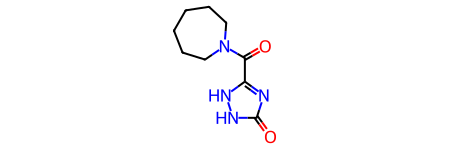

In [131]:
deck.lookup['O=C(c1nc(=O)[nH][nH]1)N1CCCCCC1']